# Increasing simulation complexity

There may be occasions where users want to incorporate additional behaviour in their simulations to make them more realistic. In CASSOM there are three ways of adding additional complexity to simulations. First is to weight the number of colonisers dispersing from a cell with the colonise control layer. Second, users can incoporate neighbourhood effects to modify the survival and colonise control layers. Lastly, users can define interactions between species, that modifies the survival control layer.

In this notebook, we will show an example simulations incorporating:
* Weighted colonisation function
* Neighbourhood effects
* Species interactions

To start with, we will load in a habitat suitability map, define the state layer and cellular automata object.

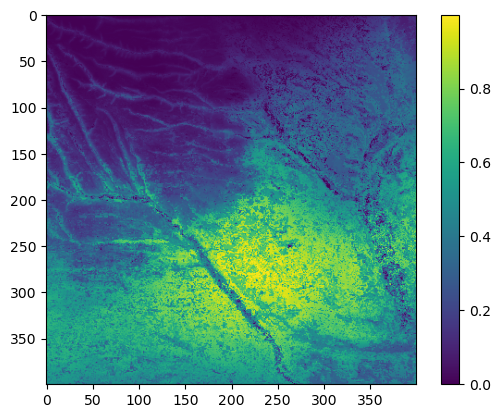

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\Liam\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


PyObject <matplotlib.colorbar.Colorbar object at 0x00000000630DEA30>

In [1]:
include("D:/git/SpatialVirtualSpecies/src/SpatialVirtualSpecies.jl")
using .SpatialVirtualSpecies
using DataFrames,DelimitedFiles
using PyPlot

header = SpatialVirtualSpecies.getHeader("D:/PHDExperimentOutputs/Transferability/landscapes/suitability/suitability789.asc",6)
suitability = readdlm("D:/PHDExperimentOutputs/Transferability/landscapes/suitability/suitability789.asc",skipstart=6)
pa = SpatialVirtualSpecies.generateStateLayer(suitability,0.01,(0.4,1.0))
paIdx = CartesianIndices(suitability)
#Create simulation constructor
ca = SpatialVirtualSpecies.SpeciesCellularAutomata(pa,paIdx,suitability,suitability)
imshow(suitability)
colorbar()

## Weighted colonisation

Weighted dispersal allows users to specify a parameter that is the mean number of colonisers that can spread from a cell. The actual number chosen is selected randomly from a Poisson distribution, with this parameter as the mean. However, the parameter is modified depending on the suitability of the cell, with more suitable areas having greater numbers of colonisers.

The rationale behind this is that if we assume a highly suitable area can support larger numbers of individuals, then there may be greater numbers of colonisers spreading from that area.

In [2]:
# Define POS parameter constructors
pos_params = SpatialVirtualSpecies.ExponentialPosSelector(3)
# Define dispersal parameters
cParam = SpatialVirtualSpecies.ColoniseWeightedParameters(pos_params,0.2,1)

Main.SpatialVirtualSpecies.ColoniseWeightedParameters(Main.SpatialVirtualSpecies.ExponentialPosSelector(3.0), 0.2, 1)

We can then define the simulate function and run the simulation

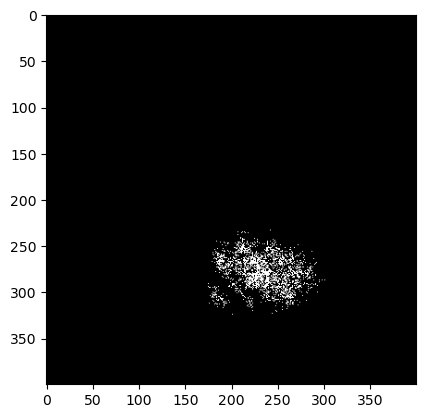

PyObject <matplotlib.image.AxesImage object at 0x000000007C9A7910>

In [88]:
function simulate(ca,cp,iterations)
    for i in 1:iterations
        SpatialVirtualSpecies.colonise(ca,cp)
        SpatialVirtualSpecies.extinction(ca)
    end
end  
simulate(ca,cParam,200)
imshow(ca.pa,cmap="gray")

## Neighbourhood effects
In the real world, an area may not simply become unoccupied, but may vary in abundance over time as populations fluctuate. There may also be spatial dynamics between populations, where highly suitable areas support greater population growth, and produce offspring that colonise less suitable areas nearby (source-sink dynamics).
We should also consider that a single timestep in our simulation tool is an abrupt event, while ecological processes operate continuously. 

With this in mind, we include a neighbourhood effect to modify the probability of persistence of the survival control layer, depending on how many nearby cells are occupied. Essentially, a greater number of occupied cells within a neighbourhood, increases the probability of persistence for a given cell.

In this example, we will show how to set up a simulation with neighbourhood effects, but also demonstrate some of the calculations.

### Setup
Users need to defined a NeighbourhoodParameters object. This holds information such as neighbourhood characteristics, the weighting for survival and colonisation as well as parameters to scale the weighting.

#### Neighbourhood type
First we need to define the neighbourhood as a Moore neighbourhood with a radius of 2 cells from the focal cell at the centre. In the colonisation and extinction functions, this neighbourhood is used to retreive the cells surrounding a focal cell using the getNeighbourhood function.

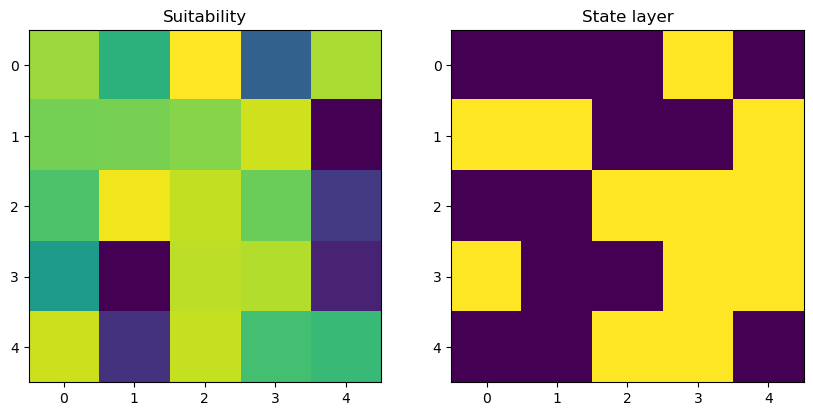

PyObject <matplotlib.image.AxesImage object at 0x000000009C46B250>

In [91]:
nt = SpatialVirtualSpecies.MooreNeighbours(2)

exampleNeighbourhood = SpatialVirtualSpecies.getNeighbourhood(nt,suitability,CartesianIndex(300,100),size(suitability))
pa = SpatialVirtualSpecies.generateStateLayer(suitability,0.5,(0.4,1.0))
occNeighbourhood  = SpatialVirtualSpecies.getNeighbourhood(nt,pa,CartesianIndex(300,100),size(pa))

fig = figure("pa",figsize=(10,10))
subplot(1,2,1)
title("Suitability")
imshow(exampleNeighbourhood)
subplot(1,2,2)
title("State layer")
imshow(occNeighbourhood)

#### Weight matrix

Next we need to define a neighbourhood weight matrix to contol how much each cell in the neighbourhood contributes to the overall neighbourhood effect. All cells could have a single value, or can be weighted by distance. For this example we'll use an inverse distance weighting

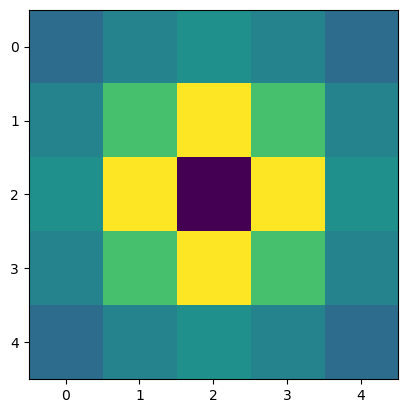

PyObject <matplotlib.image.AxesImage object at 0x000000009C5021F0>

In [92]:
wtGen = SpatialVirtualSpecies.IDW_MooreNeighbourhoodWeight(2,1,true)
wtMatrix = SpatialVirtualSpecies.generateWeightMatrix(wtGen)
imshow(wtMatrix)

#### Calculate the raw neighbourhood weight
In order to obtain a neighbourhood weighting, the suitability and weight matrix are multiplied together, so that the contribution of each cell is dependent on distance and suitability. We then also multiply this by the state layer, so only occupied cells can contribute to the final weight. Lastly, users specify a scaling factor to increase or decrease the neighbourhood weighting. Typically, values less than one are appropriate. Note, this is all done within the extinction & colonisation functions, but demonstrated here to provide better understanding.

In [7]:
nbFactor = 0.3
weight = sum(wtMatrix.*exampleNeighbourhood.*occNeighbourhood)*nbFactor

1.16136340445887

#### Scaling the neighbourhood weight
As you can see, the final weighting value is greater than one and needs to be scaled within a range. This is then scaled between zero and a maximum value. For the extinction function, the neighbourhood weight needs to be scaled to a maximum of 1, while for the colonisation process it can be set to any number. If the maximum value is one, then the mean number of colonisers doubles.

Users should note that because the raw neighbourhood weight is based on summing the neighbourhood values, larger neighbourhood sizes can produce bigger effects.

In [8]:
survivalScaling = SpatialVirtualSpecies.LogisticScalingParameters()
coloniseScaling = SpatialVirtualSpecies.LogisticScalingParameters()

Main.SpatialVirtualSpecies.LogisticScalingParameters(0.9, -10.0)

#### Running a simulation with neighbourhood effects
In order to run the simulation we intialise our neighbourhood parameter object with the neighbourhood type, factors for varying the raw neighbourhood weight, scaling function parameters and the weight matrix. 

We can then setup our simulation function the same as for before, but include the neighbourhood parameters in the colonise and extinction functions.

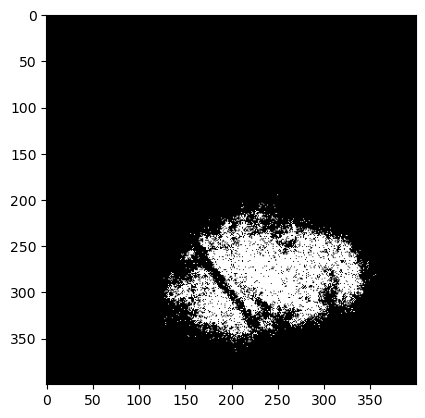

PyObject <matplotlib.image.AxesImage object at 0x000000007CB721C0>

In [95]:
nbParams = SpatialVirtualSpecies.NeighbourhoodParameters(nt,0.05,0.05,survivalScaling,coloniseScaling,wtMatrix)

function simulateNB(ca,cp,nb,iterations)
    for i in 1:iterations
        SpatialVirtualSpecies.colonise(ca,cp,nb)
        SpatialVirtualSpecies.extinction(ca,nb)
    end
end 
simulateNB(ca,cParam,nbParams,200)
imshow(ca.pa,cmap="gray")

## Species interactions
In the real world there may be cases where the range of two species may overlap, causing them to compete with one another for resources. In our CASSOM, we incorporate this type of effect by having users define two different sets of simulation parameters and colonisation and survival control layers. Users can then define interaction parameters that determines the competetive edge one species has over the other, as well as the strength of that effect.

### Defining species
First we define two species using two difference suitability maps parameter sets.

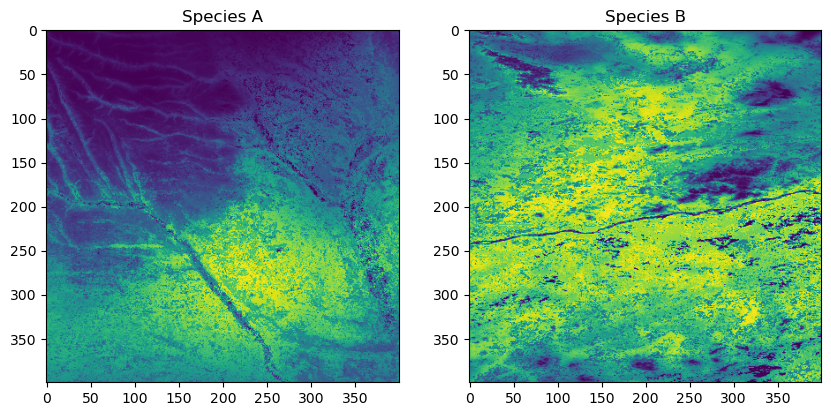

PyObject <matplotlib.image.AxesImage object at 0x00000000A224EAF0>

In [119]:
### Species A ###
suitabilityA = readdlm("D:/PHDExperimentOutputs/Transferability/landscapes/suitability/suitability789.asc",skipstart=6)
paA = SpatialVirtualSpecies.generateStateLayer(suitabilityA,0.01,(0.4,1.0))
paAIdx = CartesianIndices(suitabilityA)
#Create simulation constructor
caA = SpatialVirtualSpecies.SpeciesCellularAutomata(paA,paAIdx,suitabilityA,suitabilityA)
# Define dispersal parameters
pos_paramsA = SpatialVirtualSpecies.ExponentialPosSelector(3)
cpA = SpatialVirtualSpecies.ColoniseParameters(pos_params,0.3)

### Species B ###
suitabilityB = readdlm("D:/PHDExperimentOutputs/Transferability/landscapes/suitability/suitability32.asc",skipstart=6)
paB = SpatialVirtualSpecies.generateStateLayer(suitabilityB,0.01,(0.4,1.0))
paBIdx = CartesianIndices(suitabilityB)
#Create simulation constructor
caB = SpatialVirtualSpecies.SpeciesCellularAutomata(paB,paBIdx,suitabilityB,suitabilityB)
# Define dispersal parameters
pos_paramsB = SpatialVirtualSpecies.ExponentialPosSelector(3)
cpB = SpatialVirtualSpecies.ColoniseParameters(pos_paramsB,0.2)

fig = figure("pa",figsize=(10,10))
subplot(121)
title("Species A")
imshow(caA.survivalControl_Active)
subplot(122)
title("Species B")
imshow(caB.survivalControl_Active)

Before setting up a simulation with interactions, let's look at how the simulated distributions of these two species look when there are NO interactions effects.

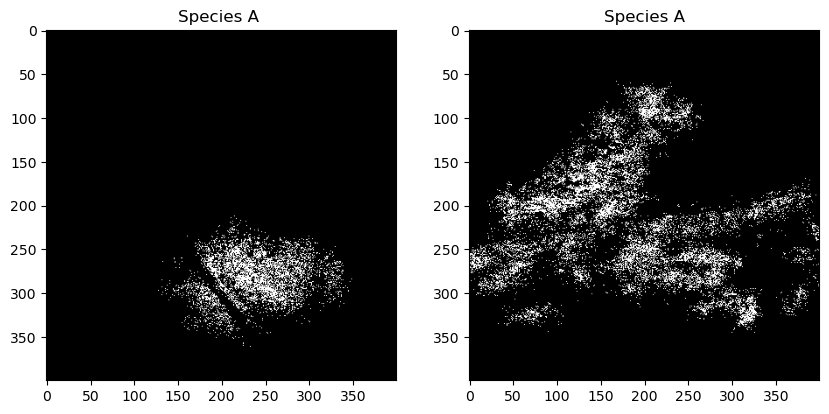

PyObject <matplotlib.image.AxesImage object at 0x00000000A11DDA00>

In [120]:
function simulate(ca,cp,iterations)
    for i in 1:iterations
        SpatialVirtualSpecies.colonise(ca,cp)
        SpatialVirtualSpecies.extinction(ca)
    end
end  
simulate(caA,cpA,200)
simulate(caB,cpB,200)

# Store as variable to compare later
caa_no_interaction = caA.pa
cab_no_interaction = caB.pa

fig = figure("pa",figsize=(10,10))
subplot(221)
title("Species A ")
imshow(caA.pa,cmap="gray")
subplot(222)
title("Species A")
imshow(caB.pa,cmap="gray")



### Defining interactions

Now we need to redefine our simulation function to include our interaction parameter object that controls the interact function. This function modifies the active survival layer of two depending on their cooccurence within a cell.

Two parameters are required, the first being the strength of the effect and the second the competetive edge. The interaction effect of Species A on B is determined by multiplying the strength and edge parameters, while the interaction effect of Species B on A is calculated the same way but using 1-edge instead.
<img src="https://render.githubusercontent.com/render/math?math=I_{AB} = \Strength*Edge">
<img src="https://render.githubusercontent.com/render/math?math=I_{BA} = \Strength*(1-Edge)">
Finally, the value of each cell in the active (a) survival control layer is modified by subtracting the current value of the passive (p) survival control layer, multiplied by the interaction effect and the state layer value. This means if a cell is not occupied by Species B, it will not be affected.
<img src="https://render.githubusercontent.com/render/math?math=S_{am} = \S_{a} - (S_{p}I_{BA}O_B))">
There is a final boolean parameter which determines if the active survival control layer is used in place of the passive survival layer. This important, as setting this to true means there will be cumulative changes to the active survival layer over each iteration. For two species interactions, it is not recommended to set this to true, but can be overcome by using the reset_active_layer function.

Below we define an interaction between Species A and B so that Species A strongly outcompetes Species B.

In [121]:
interactions = SpatialVirtualSpecies.Interaction(0.9,0.9,false)

function simulateInteractions(sA,spA,sB,spB,interactions,iterations)
    for i in 1:iterations
        SpatialVirtualSpecies.interact(interactions,sA,sB)
        SpatialVirtualSpecies.colonise(sA,spA)
        SpatialVirtualSpecies.extinction(sA)
        SpatialVirtualSpecies.colonise(sB,spB)
        SpatialVirtualSpecies.extinction(sB)
    end
end 

simulateInteractions (generic function with 1 method)

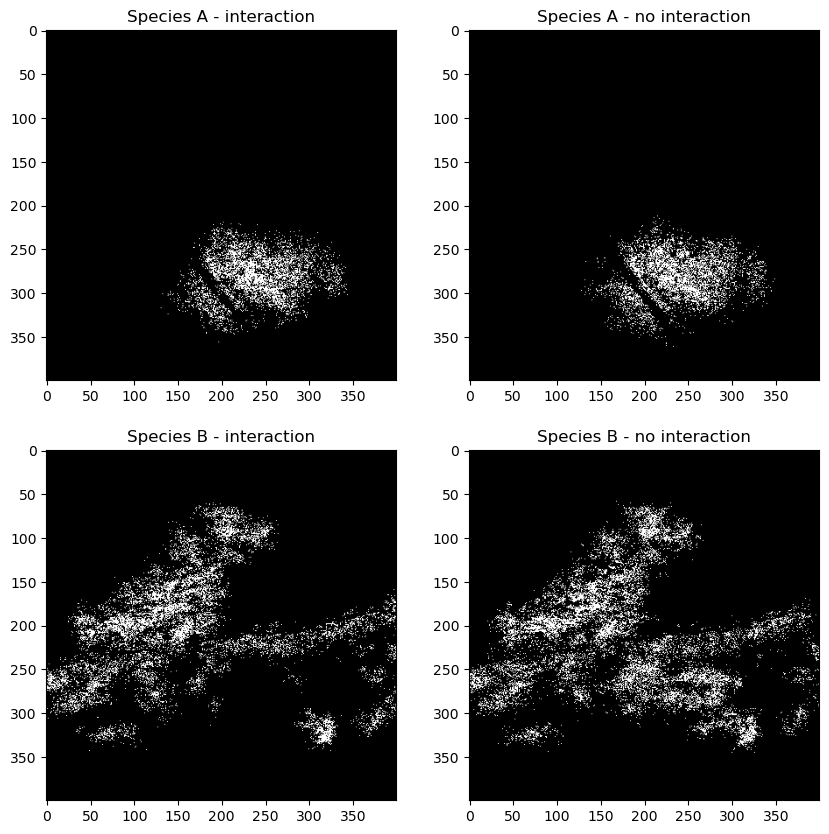

PyObject <matplotlib.image.AxesImage object at 0x00000000A12B1490>

In [122]:
# Reset the state layers
caA.pa= SpatialVirtualSpecies.generateStateLayer(suitabilityA,0.01,(0.4,1.0))
caB.pa = SpatialVirtualSpecies.generateStateLayer(suitabilityB,0.01,(0.4,1.0))
simulateInteractions(caA,cpA,caB,cpB,interactions,200)

# Store as variable to compare later
cab_one_interaction = caB.pa

fig = figure("pa",figsize=(10,10))
subplot(221)
title("Species A - interaction")
imshow(caA.pa,cmap="gray")
subplot(222)
title("Species A - no interaction")
imshow(caa_no_interaction,cmap="gray")
subplot(223)
title("Species B - interaction")
imshow(caB.pa,cmap="gray")
subplot(224)
title("Species B - no interaction")
imshow(cab_no_interaction,cmap="gray")

We can see that the distribution from species A is comparable to simulation with no interactions, but species B has portion of its range in the south-eastern quadrant that is no long occupied.

We can reverse the effect by changing the edge parameter to 0.1, so species B dominates, with the results below.

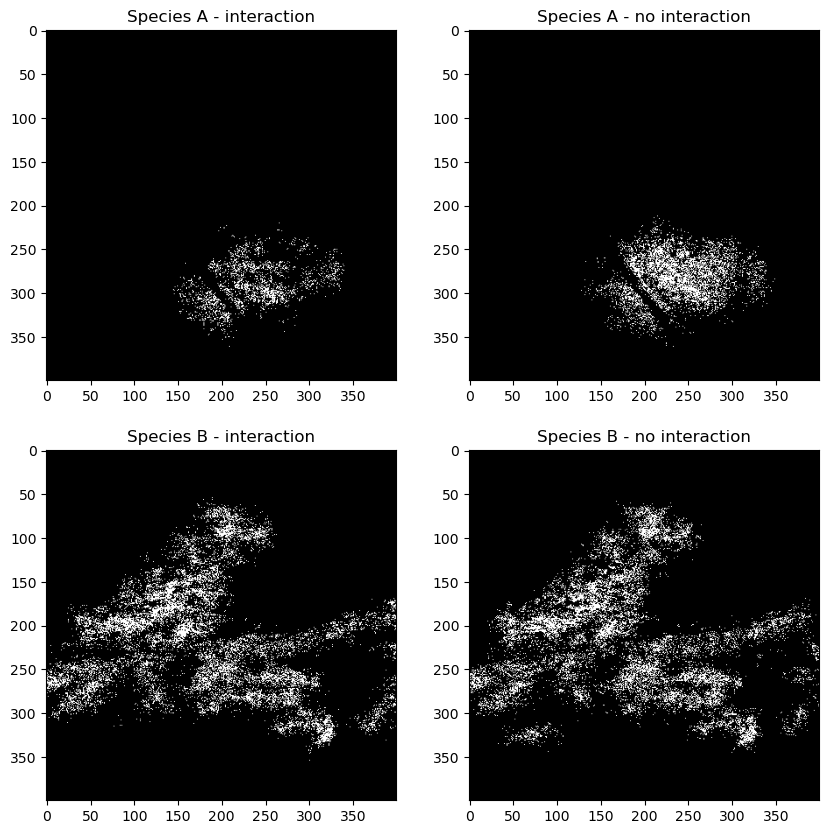

PyObject <matplotlib.image.AxesImage object at 0x00000000A3C43970>

In [123]:
# Reset the state layers
caA.pa = SpatialVirtualSpecies.generateStateLayer(suitabilityA,0.01,(0.4,1.0))
caB.pa = SpatialVirtualSpecies.generateStateLayer(suitabilityB,0.01,(0.4,1.0))
interactions = SpatialVirtualSpecies.Interaction(0.9,0.1,false)
simulateInteractions(caA,cpA,caB,cpB,interactions,200)

fig = figure("pa",figsize=(10,10))
subplot(221)
title("Species A - interaction")
imshow(caA.pa,cmap="gray")
subplot(222)
title("Species A - no interaction")
imshow(caa_no_interaction,cmap="gray")
subplot(223)
title("Species B - interaction")
imshow(caB.pa,cmap="gray")
subplot(224)
title("Species B - no interaction")
imshow(cab_no_interaction,cmap="gray")

### Interactions with 3 species

We can make things a little more complex by creating a simulation with interactions between three species. This requires a bit more thought as the additional species could interact with Species A, B or both. 
Below we define the parameters for the third species

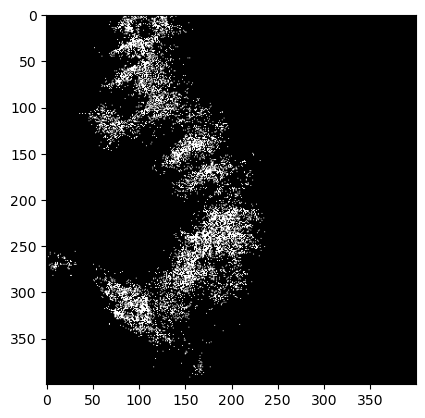

PyObject <matplotlib.image.AxesImage object at 0x00000000A157A910>

In [75]:
# Species C
suitabilityC = readdlm("D:/PHDExperimentOutputs/Transferability/landscapes/suitability/suitability785.asc",skipstart=6)
paC = SpatialVirtualSpecies.generateStateLayer(suitabilityC,0.01,(0.4,1.0))
paCIdx = CartesianIndices(suitabilityC)
#Create simulation constructor
caC = SpatialVirtualSpecies.SpeciesCellularAutomata(paC,paCIdx,suitabilityC,suitabilityC)
# Define dispersal parameters
pos_paramsC = SpatialVirtualSpecies.ExponentialPosSelector(3)
cpC = SpatialVirtualSpecies.ColoniseParameters(pos_paramsC,0.2)
simulate(caC,cpC,200)
imshow(caC.pa,cmap="gray")

Next we can define the interaction parameter objects that define how Species A interacts with Species B and Species B interacts with Species A (Note, there is no interaction between Species A and Species C). We have also set the final parameter (useActive) to true. The reason for this is that we need to run the interact function for one species pair, which modifies the active survival control layer for two species (A and B in this instance). We then need to run the interact function for the second pair. So we have to use the active survival control layer so that this layer can be modified for cooccurrences of three species for Species B. After the iteration we can reset the survival control layer for Species B and C using the reset_active_layer function.


In the updated simulation function, we apply the interact function

In [76]:
interactSpeciesAonB = SpatialVirtualSpecies.Interaction(0.9,0.9,false)
interactSpeciesBonC = SpatialVirtualSpecies.Interaction(0.9,0.1,true)
function simulateTripleInteractions(sA,spA,sB,spB,sC,spC,interaction1,interaction2,iterations)
    for i in 1:iterations
        SpatialVirtualSpecies.interact(interaction1,sA,sB)
        SpatialVirtualSpecies.interact(interaction2,sB,sC)
        SpatialVirtualSpecies.colonise(sA,spA)
        SpatialVirtualSpecies.extinction(sA)
        SpatialVirtualSpecies.colonise(sB,spB)
        SpatialVirtualSpecies.extinction(sB)
        SpatialVirtualSpecies.colonise(sC,spC)
        SpatialVirtualSpecies.extinction(sC)
        
        SpatialVirtualSpecies.reset_active_layer(sB)
        SpatialVirtualSpecies.reset_active_layer(sC)
    end
end 

simulateTripleInteractions (generic function with 1 method)

In [77]:
caA.pa= SpatialVirtualSpecies.generateStateLayer(suitabilityA,0.01,(0.4,1.0))
caB.pa = SpatialVirtualSpecies.generateStateLayer(suitabilityB,0.01,(0.4,1.0))
caC.pa= SpatialVirtualSpecies.generateStateLayer(suitabilityC,0.01,(0.4,1.0))
simulateTripleInteractions(caA,cpA,caB,cpB,caC,cpC,interaction1,interaction2,200)

In [ ]:
Below we have the three species distributions, with Species B having significant portions of its potential range unoccupied.

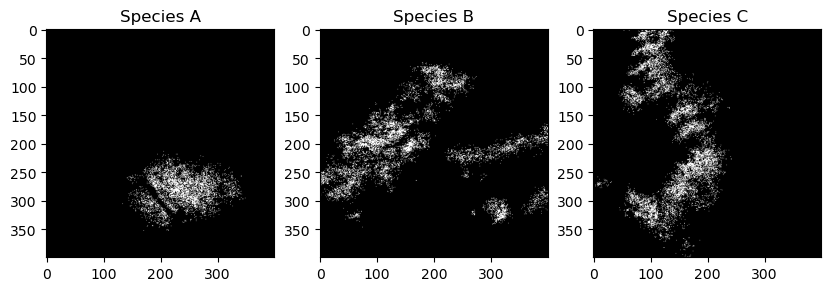

PyObject <matplotlib.image.AxesImage object at 0x00000000970A2250>

In [86]:
fig = figure("pa",figsize=(10,10))
subplot(131)
title("Species A")
imshow(caA.pa,cmap="gray")
subplot(132)
title("Species B")
imshow(caB.pa,cmap="gray")
subplot(133)
title("Species C")
imshow(caC.pa,cmap="gray")

This is demonstrate better by comparing the three simulations for Species B with no, one and two interactions

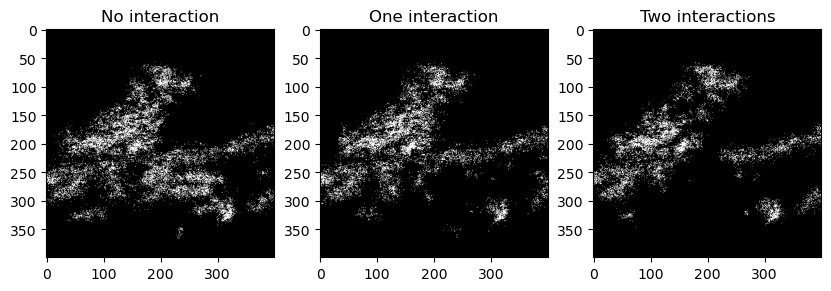

PyObject <matplotlib.image.AxesImage object at 0x0000000095532130>

In [85]:
fig = figure("pa",figsize=(10,10))
subplot(131)
title("No interaction")
imshow(cab_no_interaction,cmap="gray")
subplot(132)
title("One interaction")
imshow(cab_one_interaction,cmap="gray")
subplot(133)
title("Two interactions")
imshow(caB.pa,cmap="gray")